In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Dataset
raw_dataset = tf.data.TFRecordDataset(['birds-vs-squirrels-train.tfrecords'])
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}

# Function
def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_description)
    targets = examples.pop('label')
    images = tf.image.resize_with_pad(
        tf.cast(tf.io.decode_jpeg(examples['image'], channels=3), tf.float32), 299, 299
    ) / 255.0 
    return images, targets
dataset = raw_dataset.map(parse_examples, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000)

batch_size = 64
dataset_size = sum(1 for _ in dataset)
train_size = int(0.8 * dataset_size)
train_dataset = dataset.take(train_size).batch(batch_size, drop_remainder=True).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = dataset.skip(train_size).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

steps_per_epoch = train_size // batch_size
validation_steps = (dataset_size - train_size) // batch_size
print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")

# InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False 

# Custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  
x = Dropout(0.3)(x)
output_layer = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,  
    restore_best_weights=True
)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',  
    factor=0.5,  
    patience=2,  
    min_lr=1e-7 
)

# Training
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_scheduler] 
)

Steps per epoch: 101, Validation steps: 25
Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 33s 245ms/step - accuracy: 0.7546 - loss: 0.8631 - val_accuracy: 0.9675 - val_loss: 0.3775 - learning_rate: 1.0000e-04
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 0.9493 - loss: 0.4078 - val_accuracy: 0.9725 - val_loss: 0.3280 - learning_rate: 1.0000e-04
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.9648 - loss: 0.3610 - val_accuracy: 0.9769 - val_loss: 0.3085 - learning_rate: 1.0000e-04
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 23s 225ms/step - accuracy: 0.9700 - loss: 0.3227 - val_accuracy: 0.9787 - val_loss: 0.3030 - learning_rate: 1.0000e-04
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.9701 - loss: 0.3168 - val_accuracy: 0.9794 - val_loss: 0.2833 - learning_rate: 1.0000e-04
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 22s 221ms/step - accuracy: 0.9768 - loss: 0.2911 - val_accuracy: 0.9812 - val_loss: 0.2824 - learning_rate: 1.0000e-04
Epo

In [4]:
# Fine-Tuning
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Recompile 
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-5), 
    metrics=['accuracy']
)

# Training
fine_tune_epochs = 10  
history_fine = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=fine_tune_epochs, 
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps, 
    callbacks=[early_stopping, lr_scheduler] 
)

Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 262ms/step - accuracy: 0.9780 - loss: 0.2531 - val_accuracy: 0.9812 - val_loss: 0.2487 - learning_rate: 1.0000e-05
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.9797 - loss: 0.2443 - val_accuracy: 0.9819 - val_loss: 0.2484 - learning_rate: 1.0000e-05
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.9813 - loss: 0.2435 - val_accuracy: 0.9831 - val_loss: 0.2448 - learning_rate: 1.0000e-05
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 24s 236ms/step - accuracy: 0.9810 - loss: 0.2423 - val_accuracy: 0.9844 - val_loss: 0.2403 - learning_rate: 1.0000e-05
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 40s 396ms/step - accuracy: 0.9845 - loss: 0.2334 - val_accuracy: 0.9825 - val_loss: 0.2468 - learning_rate: 1.0000e-05
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 404ms/step - accuracy: 0.9829 - loss: 0.2332 - val_accuracy: 0.9825 - val_loss: 0.2440 - learning_rate: 1.0000e-05
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 23s 22

In [5]:
model.save('birdsVsSquirrelsModel.keras')

2025-02-27 05:24:53.694675: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-02-27 05:24:53.695204: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9418457608077279547
2025-02-27 05:24:53.695256: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15991107908622521579
/home/akhil_tom/miniconda3/envs/AppliedML_tfcuda/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


🎯 Training Accuracy: 0.9893
🎯 Validation Accuracy: 0.9844
🎯 Test Accuracy: 0.9692


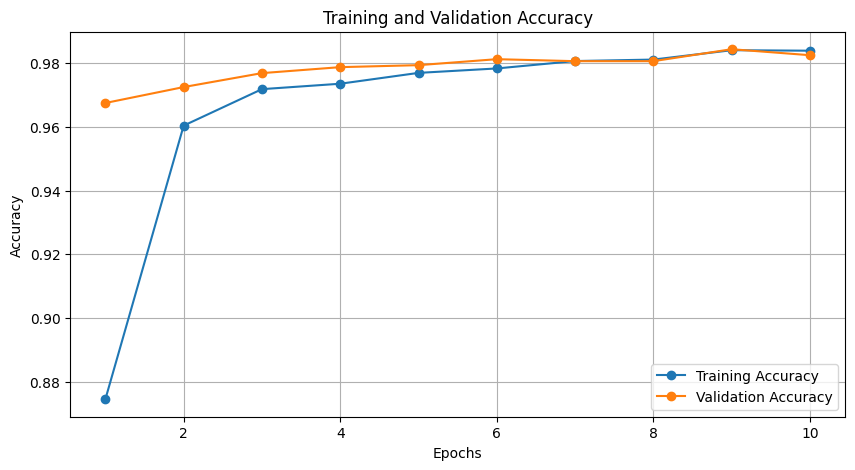

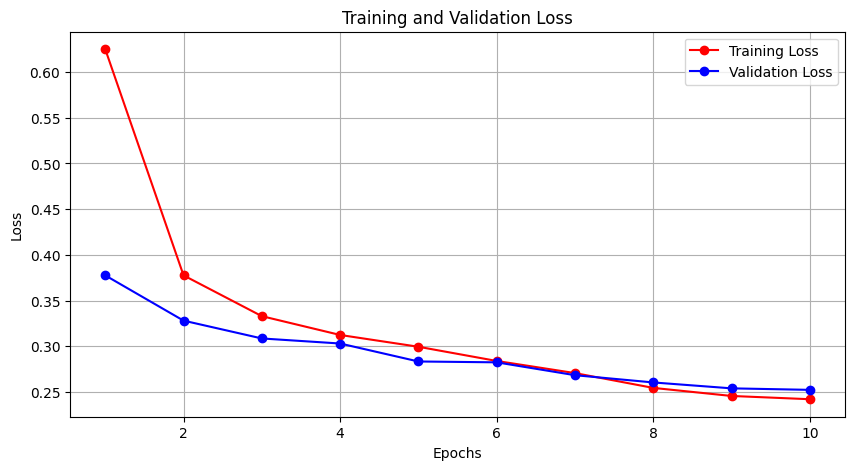

In [6]:
# Model Testing
test_dataset = tf.data.TFRecordDataset(['birds-vs-squirrels-validation.tfrecords'])
test_dataset = test_dataset.map(parse_examples).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

train_loss, train_acc = model.evaluate(train_dataset, verbose=0, steps=steps_per_epoch)
val_loss, val_acc = model.evaluate(val_dataset, verbose=0, steps=validation_steps)
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)

# Accuracies
print(f"🎯 Training Accuracy: {train_acc:.4f}")
print(f"🎯 Validation Accuracy: {val_acc:.4f}")
print(f"🎯 Test Accuracy: {test_acc:.4f}")

# Training Graphs
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o', color='red')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
